# Ames Housing Dataset -  Feature Selection

> Gianmaria Pizzo - 872966@stud.unive.it

These notebooks represent the project submission for the course [Data and Web Mining](https://www.unive.it/data/course/337525) by Professor [Claudio Lucchese](https://www.unive.it/data/people/5590426) at [Ca' Foscari University of Venice](https://www.unive.it).

---

## Structure of this notebook

This notebook covers the following points
* Feature Selection (from domain knowledge and previous evidence)
* Feature Importance (assessed through XGBoost)
* Recursive Feature Elimination (assessed through Random Forest)
* Final Dataset Overview

---

### Before running this notebook

To avoid issues, before running the following notebook it is best to
* Clean previous cell outputs
* Restart the kernel

---

###  Environment, Imports and Global Variables

In [1]:
# Interactive
%matplotlib notebook
# Static
# %matplotlib inline

# Environment for this notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
import IPython

# Set the style for the plots
sns.set()
plt.style.use('ggplot')
sns.set_style("darkgrid")
# Ignore warnings
warnings.filterwarnings('ignore') 

# Working folder
WORKING_DIR = os.getcwd()
# Resources folder
RESOURCES_DIR = os.path.join(os.getcwd(), 'resources')
# Name of file
IN_LABEL = 'ames_housing_out_1.csv'
ORIG_LABEL = 'ames_housing_out_1_orig.csv'

In [2]:
# Utils Module

def sort_alphabetically(dataset, last_label = None):
    """
    Sorts the dataset alphabetically 

    :param dataset: a pd.DataFrame
    :param last_label: a str containing an existing column label in the dataset
    :returns: pd.DataFrame
    """
    # Sort
    dataset = dataset.reindex(sorted(dataset.columns), axis=1)
    # Move target column to last index
    if last_label is not None:
        col = dataset.pop(last_label)
        dataset.insert(dataset.shape[1], last_label, col)
    return dataset

In [3]:
# Module for correlation analysis

def display_corr_matrix(dataset: pd.core.frame.DataFrame, label: str, exclude = None):
    """
    Displays the correlation matrix and returns it
    : param dataset: pd.core.frame.DataFrame
    : param label: str representing an existing column
    : param exclude: list of str of features to exclude
    : returns: correlation matrix
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    
    if exclude is not None:
        if type(exclude) == list:
            for i in exclude:
                if type(i)!= str:
                    raise Exception("exclude must be a list of string")
                if i not in dataset.columns:
                    raise Exception(i + " is not a valid column label")
        else:
            raise Exception("exclude must be a list")
            
    # Move target column to last index
    col = dataset.pop(label)
    dataset.insert(dataset.shape[1], label, col)

    plt.figure(figsize=(20,20))
    
    matrix = dataset.corr()

    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                 n=9, center="light", as_cmap=True)
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    sns.heatmap(matrix, mask=mask, center=0, annot=True,
                 fmt='.2f', square=True, cmap=cmap)
    return matrix


def top_correlated_features(corr_matrix, label, threshold=0.45):
    m = corr[label].sort_values(ascending=False).to_dict()
    corr_dict = {}
    
    for k in m:
        if label in k:
            continue
        else:
            v = m.get(k)
            if v >= threshold or v <= (-threshold):
                corr_dict.update({k:v})
    return corr_dict


def display_correlation(sample_dict, exclude=None):
    for k in sample_dict:
        print("Top correlated features with \"{0}\"".format(k))
        temp = top_correlated_features(corr, k, .60)
        for k in temp:
            if exclude is not None and k in exclude:
                continue
            print("\t{0} : {1}".format(k, temp.get(k)))
        print("\n")
    pass

In [4]:
from sklearn.model_selection import train_test_split

# Module for train test split

def get_X_y(dataset, label, ignore=None):
    """
    Returns X and y and ignores labels in ignore
    :param dataset: a pd.DataFrame
    :param label: a str containing an existing target column label in the dataset
    :param ignore: a list of str containing an existing column label in the dataset to ignore
    :returns: tuple of pd.DataFrame
    """
    if ignore is not None:
        # Drop the labels 
        all_columns = list(dataset.columns)
        # Include only columns that are existing 
        to_drop = [i for i in all_columns if i in ignore] +[label]
        return dataset.drop(columns=to_drop), dataset[[label]]
    return dataset.drop(columns=[label]), dataset[[label]]

def get_train_test(X, y, size = 0.2, state = 33):
    """
    Returns X_train_[size], X_test, y_train_[size], y_test
    :param X: a pd.DataFrame without the target column
    :param y: a pd.DataFrame with one column, the target
    :param size: a float representing the fraction for the test size
    :param state: an integer representing the random state for the test
    :returns: 4 pd.DataFrame usually called "X_train_[size], X_test, y_train_[size], y_test"
    """
    return train_test_split(X, y, test_size=size, random_state = state)

def get_train_val_test(X, y, size_t=0.2, size_v=0.25, state_v = 42):
    """
    Returns X_train, X_valid, X_test, y_train, y_valid, y_test
    :param X: a pd.DataFrame without the target column
    :param y: a pd.DataFrame with one column, the target
    :param size_t: a float representing the fraction for the test size
    :param size_v: a float representing the fraction for the validation
    :param state_v: an integer representing the random state for the validation
    :returns: 6 pd.DataFrame usually called X_train, X_valid, X_test, y_train, y_valid, y_test
    """
    X_train_s, X_test, y_train_s, y_test = get_train_test(X, y, size = size_t)
    X_train, X_valid, y_train, y_valid = get_train_test(X_train_s, y_train_s, size = size_v, state = state_v)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
from xgboost import XGBRegressor
from xgboost import plot_importance
# Module for feature importances

def plot_feature_importances(model, dataset):
    n_features = x.shape[1]
    plt.barh(range(n_features),model.feature_importances_,align="center")
    plt.yticks(np.arange(n_features),x)
    plt.xlabel("importance")
    plt.ylabel("features")
    plt.show
    pass

def plot_xgb_importance(dataset, target, ignore = None,  subset= None):
    # Data
    X, y = get_X_y(dataset=dataset, 
                   label=target, ignore=ignore)
    X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_val_test(X, y, size_t=0.2, size_v=0.25, state_v = 42)
    # Model
    model = XGBRegressor(n_estimators = 10,
                         max_depth = 12,
                         max_leaves = 12,
                         learning_rate = 0.5, 
                         importance_type = 'weight',
                         sampling_method = 'gradient_based', 
                         random_state = 292359329)
    # Fit
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],verbose=False)
    # Importance
    plot_importance(model, max_num_features = 30)
    plt.show()
    return list(model.feature_names_in_)

In [6]:
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

# Module for RFECV

def rfe_estim(dataset, target, estimator, cv, ignore=None):
    X, y = get_X_y(dataset=dataset, label=target, ignore=ignore)
    selector = RFECV(estimator=estimator, 
                     step=1, 
                     min_features_to_select=30, 
                     cv= cv, 
                     scoring='neg_mean_squared_error', 
                     n_jobs=-1, importance_getter='auto')
    selector = selector.fit(X, y)
    
    print('The optimal number of features is {}'.format(selector.n_features_))
    features = [f for f,s in zip(X.columns, selector.support_) if s]
    print('The selected features are:')
    print ('{}'.format(features))
    return features

In [7]:
df = pd.read_csv(os.path.join(RESOURCES_DIR, IN_LABEL))
df_orig = pd.read_csv(os.path.join(RESOURCES_DIR, ORIG_LABEL))

df.drop(columns='Unnamed: 0', inplace=True)
df_orig.drop(columns='Unnamed: 0', inplace=True)

df = sort_alphabetically(df, 'Sale_Price')
df_orig = sort_alphabetically(df_orig, 'Sale_Price')

---

## Removing obvious misleading and irrelevant attributes

From our previous analysis we have some level of insight about what features we want to consider.
* We are obviously going to remove the `Latitude` and `Logitude` as these feature are most likely leading to overfitting, but they are still needed for the GNN, so we are going to ignore them for now.
* Other features are not really useful from what we learnt and we ar going to show this with feature importance
* Others were the result of the combinations or transformations of initial features

We are going to take into account these information to avoid redundancy in the dataset

---

## Feature Importance

Impurting feature importance through Correlation, Xgboost Importance Estimation, and RFE

### Correlation

<IPython.core.display.Javascript object>


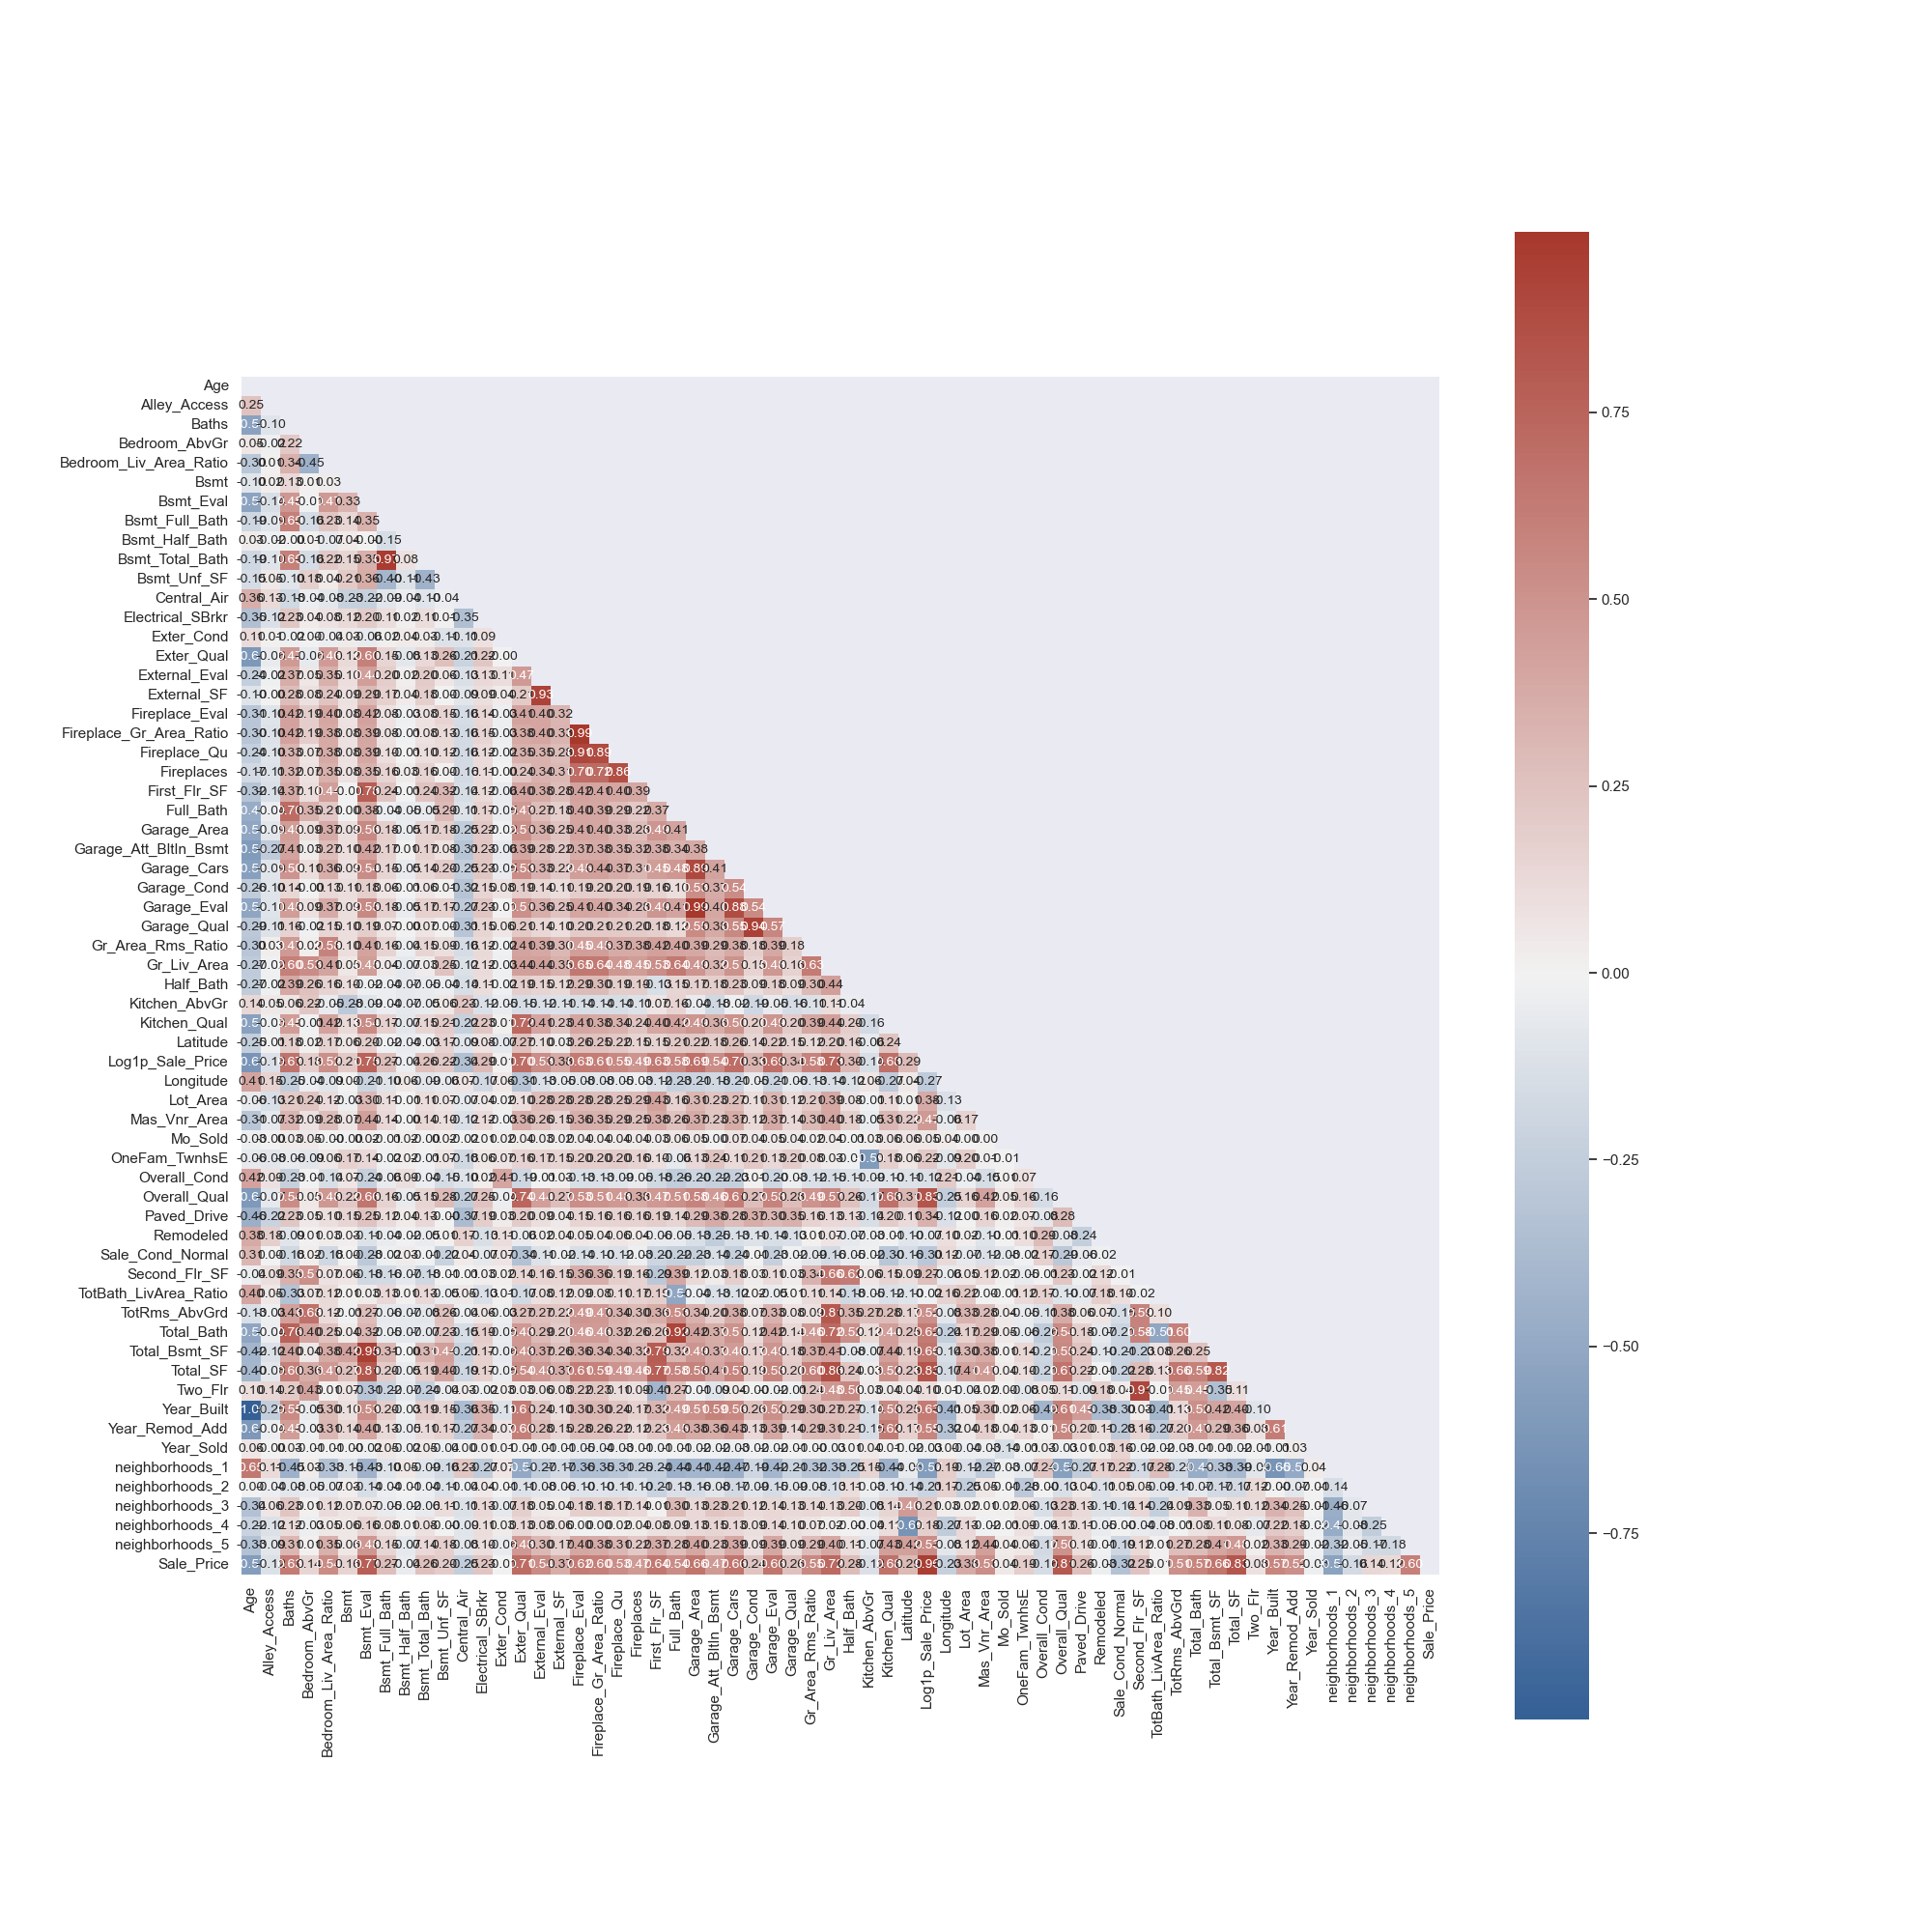

In [8]:
corr = display_corr_matrix(sort_alphabetically(df, 'Sale_Price'), label='Sale_Price')

In [9]:
top_corr_dict = top_correlated_features(corr, 'Sale_Price', 0.40)
top_corr_dict

{'Total_SF': 0.8269756936865705,
 'Overall_Qual': 0.8060232550789197,
 'Bsmt_Eval': 0.7742972743488156,
 'Gr_Liv_Area': 0.7244911339727119,
 'Exter_Qual': 0.7084917826026513,
 'Kitchen_Qual': 0.6788540968901408,
 'Total_Bsmt_SF': 0.6628925522161351,
 'Garage_Eval': 0.6626117564747573,
 'Garage_Area': 0.6617725362684803,
 'Garage_Cars': 0.6592190284190094,
 'First_Flr_SF': 0.6447995871460168,
 'Baths': 0.6323840093514431,
 'Fireplace_Eval': 0.6247559650346689,
 'neighborhoods_5': 0.6024480653810578,
 'Fireplace_Gr_Area_Ratio': 0.6000697984719248,
 'Year_Built': 0.572891779703003,
 'Total_Bath': 0.5726811870691908,
 'Gr_Area_Rms_Ratio': 0.5536252857760295,
 'Bedroom_Liv_Area_Ratio': 0.5448702098944762,
 'External_Eval': 0.5443530786808684,
 'Full_Bath': 0.5367717342044693,
 'Fireplace_Qu': 0.5313497695664223,
 'Mas_Vnr_Area': 0.5272438948275818,
 'Year_Remod_Add': 0.5243101828667794,
 'TotRms_AbvGrd': 0.509399290916011,
 'Fireplaces': 0.46997351394591613,
 'Garage_Att_BltIn_Bsmt': 0.4669

It is easy to understand the correlation between these variables and the target feature, as almost each one of the datasets shows almost always the same estimated correlations. However, as the result might be biased by the presence of multiple variables, we want to try another approach.

### XGBoost Regressor - Feature Importance

We can use the XGboost regressor to infer importance of features, as these kinds of trees present a way to infer it based on some metrics such as coverage or weight. 

<IPython.core.display.Javascript object>


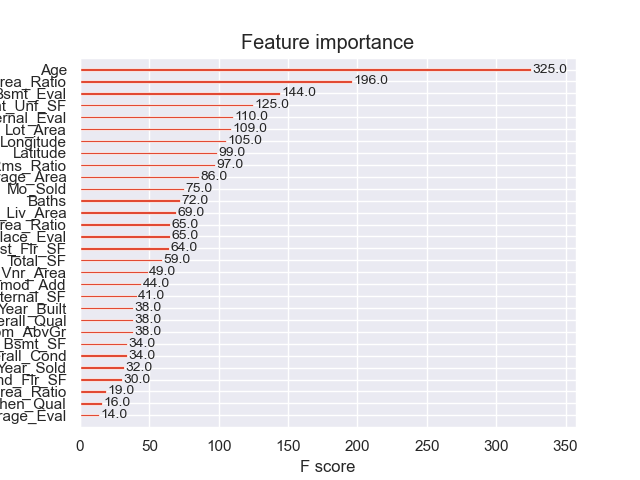

['Age',
 'Alley_Access',
 'Baths',
 'Bedroom_AbvGr',
 'Bedroom_Liv_Area_Ratio',
 'Bsmt',
 'Bsmt_Eval',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath',
 'Bsmt_Total_Bath',
 'Bsmt_Unf_SF',
 'Central_Air',
 'Electrical_SBrkr',
 'Exter_Cond',
 'Exter_Qual',
 'External_Eval',
 'External_SF',
 'Fireplace_Eval',
 'Fireplace_Gr_Area_Ratio',
 'Fireplace_Qu',
 'Fireplaces',
 'First_Flr_SF',
 'Full_Bath',
 'Garage_Area',
 'Garage_Att_BltIn_Bsmt',
 'Garage_Cars',
 'Garage_Cond',
 'Garage_Eval',
 'Garage_Qual',
 'Gr_Area_Rms_Ratio',
 'Gr_Liv_Area',
 'Half_Bath',
 'Kitchen_AbvGr',
 'Kitchen_Qual',
 'Latitude',
 'Longitude',
 'Lot_Area',
 'Mas_Vnr_Area',
 'Mo_Sold',
 'OneFam_TwnhsE',
 'Overall_Cond',
 'Overall_Qual',
 'Paved_Drive',
 'Remodeled',
 'Sale_Cond_Normal',
 'Second_Flr_SF',
 'TotBath_LivArea_Ratio',
 'TotRms_AbvGrd',
 'Total_Bath',
 'Total_Bsmt_SF',
 'Total_SF',
 'Two_Flr',
 'Year_Built',
 'Year_Remod_Add',
 'Year_Sold',
 'neighborhoods_1',
 'neighborhoods_2',
 'neighborhoods_3',
 'neighborhoods_4',

In [10]:
plot_xgb_importance(dataset = df, target = 'Sale_Price', ignore = 'Log1p_Sale_Price')

<IPython.core.display.Javascript object>


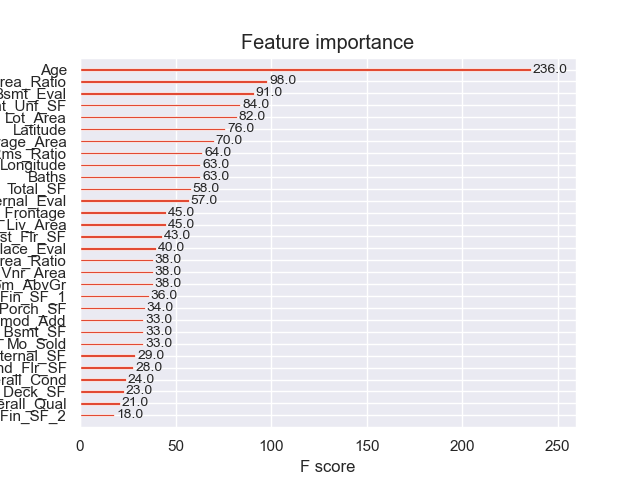

['0.0',
 '1.0',
 '2.0',
 '3.0',
 '4.0',
 '5.0',
 '6.0',
 '7.0',
 'A_agr',
 'Age',
 'AllPub',
 'Alley_Access',
 'Artery',
 'AsbShng',
 'AsphShn',
 'Baths',
 'Bedroom_AbvGr',
 'Bedroom_Liv_Area_Ratio',
 'Brk Cmn',
 'BrkComm',
 'BrkFace',
 'BrkTil',
 'Bsmt',
 'BsmtFin_SF_1',
 'BsmtFin_SF_2',
 'BsmtFin_Type_1',
 'BsmtFin_Type_2',
 'Bsmt_Cond',
 'Bsmt_Eval',
 'Bsmt_Exposure',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath',
 'Bsmt_Qual',
 'Bsmt_Total_Bath',
 'Bsmt_Unf_SF',
 'CBlock',
 'COD',
 'CWD',
 'C_all',
 'CemntBd',
 'Central_Air',
 'ClyTile',
 'CmentBd',
 'CompShg',
 'Con',
 'ConLD',
 'ConLI',
 'ConLw',
 'Corner',
 'CulDSac',
 'Duplex_All_Styles_and_Ages',
 'Electrical_SBrkr',
 'Elev',
 'Enclosed_Porch',
 'Exter_Cond',
 'Exter_Qual',
 'External_Eval',
 'External_SF',
 'FR2',
 'FR3',
 'Feedr',
 'Fence',
 'Fireplace_Eval',
 'Fireplace_Gr_Area_Ratio',
 'Fireplace_Qu',
 'Fireplaces',
 'First_Flr_SF',
 'Flat',
 'Floating_Village_Residential',
 'Floor',
 'Full_Bath',
 'Functional',
 'Gable',
 'Gambrel

In [11]:
plot_xgb_importance(dataset = df_orig, target = 'Sale_Price', ignore = 'Log1p_Sale_Price')

As we predicted, most of the features we showed during the EDA, are relevant!

Let us re-iter this by considering the combinations and omitting the original features.

<IPython.core.display.Javascript object>


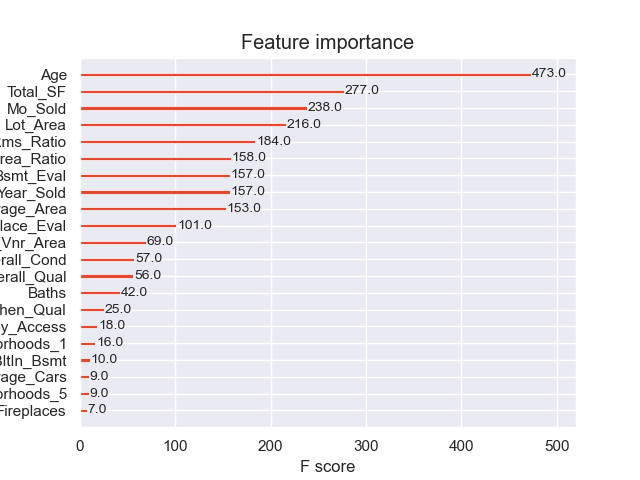

['Age',
 'Year_Sold',
 'Mo_Sold',
 'Alley_Access',
 'Total_SF',
 'Lot_Area',
 'Gr_Area_Rms_Ratio',
 'Bedroom_Liv_Area_Ratio',
 'Kitchen_Qual',
 'Fireplace_Eval',
 'Fireplaces',
 'neighborhoods_5',
 'neighborhoods_1',
 'Garage_Area',
 'Garage_Cars',
 'Garage_Att_BltIn_Bsmt',
 'Bsmt_Eval',
 'Baths',
 'Mas_Vnr_Area',
 'Overall_Qual',
 'Overall_Cond']

In [12]:
subset_1 = ['Age', 'Year_Sold', 'Mo_Sold', 
            'Alley_Access', 
            'Total_SF', 'Lot_Area',
            'Gr_Area_Rms_Ratio', 'Bedroom_Liv_Area_Ratio',
            'Kitchen_Qual', 'Fireplace_Eval', 'Fireplaces', 
            'neighborhoods_5', 'neighborhoods_1', 
            'Garage_Area', 'Garage_Cars','Garage_Att_BltIn_Bsmt',
            'Bsmt_Eval', 'Baths', 'Mas_Vnr_Area',
            'Overall_Qual', 'Overall_Cond', 'Sale_Price']

plot_xgb_importance(dataset = df[subset_1], target = 'Sale_Price')

## Recursive Feature Elimination

Since we have seen that we really want to use the sale price, we prefer to ignore the logarithm transformation to avoid the variance it might cause

In [13]:
xgb = XGBRegressor(n_estimators = 10,
                             max_depth = 7,
                             max_leaves = 10,
                             learning_rate = 0.5, 
                             importance_type = 'weight',
                             sampling_method = 'gradient_based', 
                             random_state = 292359329)
cv_rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2652124)

In [14]:
f1 = rfe_estim(df, target = 'Sale_Price', estimator = xgb, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 32
The selected features are:
['Age', 'Baths', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'Bsmt_Eval', 'Bsmt_Full_Bath', 'Bsmt_Unf_SF', 'Exter_Qual', 'External_Eval', 'External_SF', 'Fireplace_Eval', 'Fireplace_Gr_Area_Ratio', 'First_Flr_SF', 'Garage_Area', 'Garage_Eval', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Kitchen_Qual', 'Latitude', 'Longitude', 'Lot_Area', 'Mas_Vnr_Area', 'Mo_Sold', 'Overall_Cond', 'Overall_Qual', 'Second_Flr_SF', 'TotBath_LivArea_Ratio', 'Total_Bsmt_SF', 'Total_SF', 'Year_Built', 'Year_Remod_Add', 'Year_Sold']


In [15]:
f2 = rfe_estim(df_orig, target = 'Sale_Price', estimator = xgb, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 59
The selected features are:
['6.0', '7.0', 'Age', 'AsbShng', 'Baths', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'BsmtFin_Type_1', 'Bsmt_Eval', 'Bsmt_Exposure', 'Bsmt_Qual', 'Bsmt_Total_Bath', 'Bsmt_Unf_SF', 'C_all', 'Central_Air', 'Exter_Cond', 'External_Eval', 'External_SF', 'Fireplace_Eval', 'Fireplace_Gr_Area_Ratio', 'Fireplace_Qu', 'Fireplaces', 'First_Flr_SF', 'Functional', 'Garage_Area', 'Garage_Eval', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Half_Bath', 'Heating_QC', 'Kitchen_Qual', 'Land_Contour', 'Latitude', 'Longitude', 'Lot_Area', 'Lot_Frontage', 'Mas_Vnr_1', 'Mas_Vnr_Area', 'Mo_Sold', 'New', 'Open_Porch_SF', 'Overall_Cond', 'Overall_Qual', 'Remodeled', 'Residential_Low_Density', 'Residential_Medium_Density', 'Sale_Cond_Normal', 'Screen_Porch', 'Second_Flr_SF', 'TotBath_LivArea_Ratio', 'TotRms_AbvGrd', 'Total_Bsmt_SF', 'Total_SF', 'Wood_Deck_SF', 'Year_Built', 'Year_Remod_Add', 'Year_Sold']


In [16]:
# The features selected by the xgb combined:
list(set(f1) & set(f2))

['Mas_Vnr_Area',
 'Bedroom_Liv_Area_Ratio',
 'Total_Bsmt_SF',
 'Mo_Sold',
 'Lot_Area',
 'Bedroom_AbvGr',
 'TotBath_LivArea_Ratio',
 'Fireplace_Gr_Area_Ratio',
 'First_Flr_SF',
 'Gr_Liv_Area',
 'Garage_Area',
 'Bsmt_Unf_SF',
 'Bsmt_Eval',
 'Age',
 'Second_Flr_SF',
 'Total_SF',
 'Overall_Qual',
 'Year_Remod_Add',
 'Gr_Area_Rms_Ratio',
 'External_SF',
 'Longitude',
 'External_Eval',
 'Year_Sold',
 'Kitchen_Qual',
 'Overall_Cond',
 'Fireplace_Eval',
 'Latitude',
 'Baths',
 'Garage_Eval',
 'Year_Built']

As we can see the RFE on the original datasets almost always leads to a higher number of features. Now, for the sake of choosing a good subset of features, we can try with a naive random forest approach:

In [17]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=7,
                           bootstrap=True, 
                           n_jobs=-1, 
                           random_state=2546243645, 
                           verbose=0)

In [18]:
f3 = rfe_estim(df, target = 'Sale_Price', estimator = rf, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 53
The selected features are:
['Age', 'Baths', 'Bedroom_AbvGr', 'Bedroom_Liv_Area_Ratio', 'Bsmt_Eval', 'Bsmt_Full_Bath', 'Bsmt_Total_Bath', 'Bsmt_Unf_SF', 'Central_Air', 'Electrical_SBrkr', 'Exter_Qual', 'External_Eval', 'External_SF', 'Fireplace_Eval', 'Fireplace_Gr_Area_Ratio', 'Fireplace_Qu', 'Fireplaces', 'First_Flr_SF', 'Full_Bath', 'Garage_Area', 'Garage_Att_BltIn_Bsmt', 'Garage_Cars', 'Garage_Cond', 'Garage_Eval', 'Garage_Qual', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Half_Bath', 'Kitchen_AbvGr', 'Kitchen_Qual', 'Latitude', 'Longitude', 'Lot_Area', 'Mas_Vnr_Area', 'Mo_Sold', 'OneFam_TwnhsE', 'Overall_Cond', 'Overall_Qual', 'Paved_Drive', 'Remodeled', 'Sale_Cond_Normal', 'Second_Flr_SF', 'TotBath_LivArea_Ratio', 'TotRms_AbvGrd', 'Total_Bath', 'Total_Bsmt_SF', 'Total_SF', 'Year_Built', 'Year_Remod_Add', 'Year_Sold', 'neighborhoods_1', 'neighborhoods_4', 'neighborhoods_5']


In [19]:
f4 = rfe_estim(df_orig, target = 'Sale_Price', estimator = rf, cv=cv_rkf, ignore = 'Log1p_Sale_Price')

The optimal number of features is 66
The selected features are:
['Age', 'Alley_Access', 'Baths', 'Bedroom_Liv_Area_Ratio', 'BsmtFin_Type_1', 'Bsmt_Eval', 'Bsmt_Exposure', 'Bsmt_Qual', 'Bsmt_Total_Bath', 'Bsmt_Unf_SF', 'Central_Air', 'Exter_Cond', 'Exter_Qual', 'External_Eval', 'External_SF', 'Fireplace_Eval', 'Fireplace_Gr_Area_Ratio', 'Fireplace_Qu', 'Fireplaces', 'First_Flr_SF', 'Full_Bath', 'Garage_Area', 'Garage_Att_BltIn_Bsmt', 'Garage_Cars', 'Garage_Cond', 'Garage_Eval', 'Garage_Finish', 'Garage_Qual', 'Gr_Area_Rms_Ratio', 'Gr_Liv_Area', 'Hip', 'Kitchen_Qual', 'Land_Contour', 'Land_Slope', 'Latitude', 'Longitude', 'Lot_Area', 'Lot_Frontage', 'Mas_Vnr_1', 'Mas_Vnr_Area', 'Mo_Sold', 'New', 'OneFam_TwnhsE', 'Open_Porch_SF', 'Overall_Cond', 'Overall_Qual', 'PConc', 'Paved_Drive', 'Residential_Low_Density', 'Residential_Medium_Density', 'Sale_Cond_Normal', 'Second_Flr_SF', 'TotBath_LivArea_Ratio', 'TotRms_AbvGrd', 'Total_Bath', 'Total_Bsmt_SF', 'Total_SF', 'VinylSd', 'WD ', 'Wood_Deck

In [20]:
list(set(f3) & set(f4))

['OneFam_TwnhsE',
 'Mas_Vnr_Area',
 'Sale_Cond_Normal',
 'Bedroom_Liv_Area_Ratio',
 'Bsmt_Total_Bath',
 'Fireplaces',
 'Paved_Drive',
 'Total_Bsmt_SF',
 'Mo_Sold',
 'Lot_Area',
 'neighborhoods_5',
 'neighborhoods_1',
 'TotBath_LivArea_Ratio',
 'Fireplace_Gr_Area_Ratio',
 'First_Flr_SF',
 'Total_Bath',
 'Full_Bath',
 'Gr_Liv_Area',
 'Garage_Cars',
 'Garage_Area',
 'Bsmt_Unf_SF',
 'Fireplace_Qu',
 'Bsmt_Eval',
 'Age',
 'Second_Flr_SF',
 'Total_SF',
 'Overall_Qual',
 'Central_Air',
 'Garage_Att_BltIn_Bsmt',
 'Year_Remod_Add',
 'Gr_Area_Rms_Ratio',
 'External_SF',
 'neighborhoods_4',
 'Longitude',
 'External_Eval',
 'Garage_Qual',
 'Exter_Qual',
 'Year_Sold',
 'Kitchen_Qual',
 'Overall_Cond',
 'Fireplace_Eval',
 'Latitude',
 'Baths',
 'TotRms_AbvGrd',
 'Garage_Cond',
 'Garage_Eval',
 'Year_Built']

As we predicted the OHE has affected the base estimator, and we should probably look at the results from f7 and f8 for a more parsimonious model!

In [21]:
list((set(f3) & set(f4)) & (set(f3) & set(f4)))

['OneFam_TwnhsE',
 'Mas_Vnr_Area',
 'Sale_Cond_Normal',
 'Bedroom_Liv_Area_Ratio',
 'Bsmt_Total_Bath',
 'Fireplaces',
 'Paved_Drive',
 'Total_Bsmt_SF',
 'Mo_Sold',
 'Lot_Area',
 'neighborhoods_5',
 'neighborhoods_1',
 'TotBath_LivArea_Ratio',
 'Fireplace_Gr_Area_Ratio',
 'First_Flr_SF',
 'Full_Bath',
 'Total_Bath',
 'Gr_Liv_Area',
 'Garage_Cars',
 'Garage_Area',
 'Bsmt_Unf_SF',
 'Fireplace_Qu',
 'Bsmt_Eval',
 'Age',
 'Second_Flr_SF',
 'Total_SF',
 'Overall_Qual',
 'Central_Air',
 'Garage_Att_BltIn_Bsmt',
 'Year_Remod_Add',
 'Gr_Area_Rms_Ratio',
 'External_SF',
 'neighborhoods_4',
 'Longitude',
 'External_Eval',
 'Garage_Qual',
 'Exter_Qual',
 'Year_Sold',
 'Kitchen_Qual',
 'Overall_Cond',
 'Fireplace_Eval',
 'Latitude',
 'Baths',
 'TotRms_AbvGrd',
 'Garage_Cond',
 'Garage_Eval',
 'Year_Built']

---

## Feature Selection

Now we shall find a compromise between all the features in order to save just the important ones for the boosted random forest.
For what concerns the GCN, we are going to add some more features since some of them are just the encoding of previous categorical features.

From all the analysis done until now, I personally believe this is the best subset to use

In [22]:
subset = [ 
    'Age','Remodeled', 
    'Year_Sold', 'Mo_Sold',
    'Latitude','Longitude',
    'Lot_Area', 'Total_SF',
    'Baths',
    'Bedroom_AbvGr', 'TotRms_AbvGrd', 
    'Gr_Area_Rms_Ratio',
    'Bedroom_Liv_Area_Ratio',
    'TotBath_LivArea_Ratio',
    'Fireplace_Eval', 'Fireplaces',
    'Kitchen_AbvGr', 'Kitchen_Qual',
    'Garage_Area', 'Garage_Cars', 'Garage_Att_BltIn_Bsmt',
    'Total_Bsmt_SF', 'Bsmt_Unf_SF', 'Bsmt_Eval', 'Bsmt',
    'Central_Air','Electrical_SBrkr', 'Paved_Drive', 'Alley_Access',
    'Mas_Vnr_Area', 
    'External_Eval', 
    'Overall_Cond', 'Overall_Qual',
    'neighborhoods_1', 'neighborhoods_5',
    'Sale_Cond_Normal', 'OneFam_TwnhsE',
    'Sale_Price']

df[subset]

,Age,Remodeled,Year_Sold,Mo_Sold,Latitude,Longitude,Lot_Area,Total_SF,Baths,Bedroom_AbvGr,...,Alley_Access,Mas_Vnr_Area,External_Eval,Overall_Cond,Overall_Qual,neighborhoods_1,neighborhoods_5,Sale_Cond_Normal,OneFam_TwnhsE,Sale_Price
0,50.0,0.0,2010.0,5.0,42.054035,-93.619750,31770.0,2736.0,2.0,3.0,...,0.0,112.0,353.59998,4.0,5.0,1.0,0.0,1.0,1.0,215000.0
1,49.0,0.0,2010.0,6.0,42.053013,-93.619760,11622.0,1778.0,1.0,2.0,...,0.0,0.0,338.00000,5.0,4.0,1.0,0.0,1.0,1.0,105000.0
2,52.0,0.0,2010.0,6.0,42.052658,-93.619385,14267.0,2658.0,1.5,3.0,...,0.0,108.0,557.69995,5.0,5.0,1.0,0.0,1.0,1.0,172000.0
3,42.0,0.0,2010.0,4.0,42.051247,-93.617320,11160.0,4220.0,3.5,3.0,...,0.0,0.0,0.00000,4.0,6.0,1.0,0.0,1.0,1.0,244000.0
4,13.0,1.0,2010.0,3.0,42.060898,-93.638930,13830.0,2557.0,2.5,3.0,...,0.0,0.0,319.80000,4.0,4.0,0.0,0.0,1.0,1.0,189900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,22.0,0.0,2006.0,3.0,41.988964,-93.604774,7937.0,2006.0,2.0,3.0,...,0.0,0.0,156.00000,5.0,5.0,0.0,0.0,1.0,1.0,142500.0
2640,23.0,0.0,2006.0,6.0,41.988316,-93.602680,8885.0,1766.0,2.0,2.0,...,0.0,0.0,213.20000,4.0,4.0,0.0,0.0,1.0,1.0,131000.0
2641,14.0,0.0,2006.0,7.0,41.986510,-93.606850,10441.0,1882.0,1.5,3.0,...,0.0,0.0,145.59999,4.0,4.0,0.0,0.0,1.0,1.0,132000.0
2642,32.0,1.0,2006.0,4.0,41.990920,-93.600190,10010.0,2778.0,2.0,2.0,...,0.0,0.0,361.40000,4.0,4.0,0.0,0.0,1.0,1.0,170000.0


### One last time - Correlation

<IPython.core.display.Javascript object>


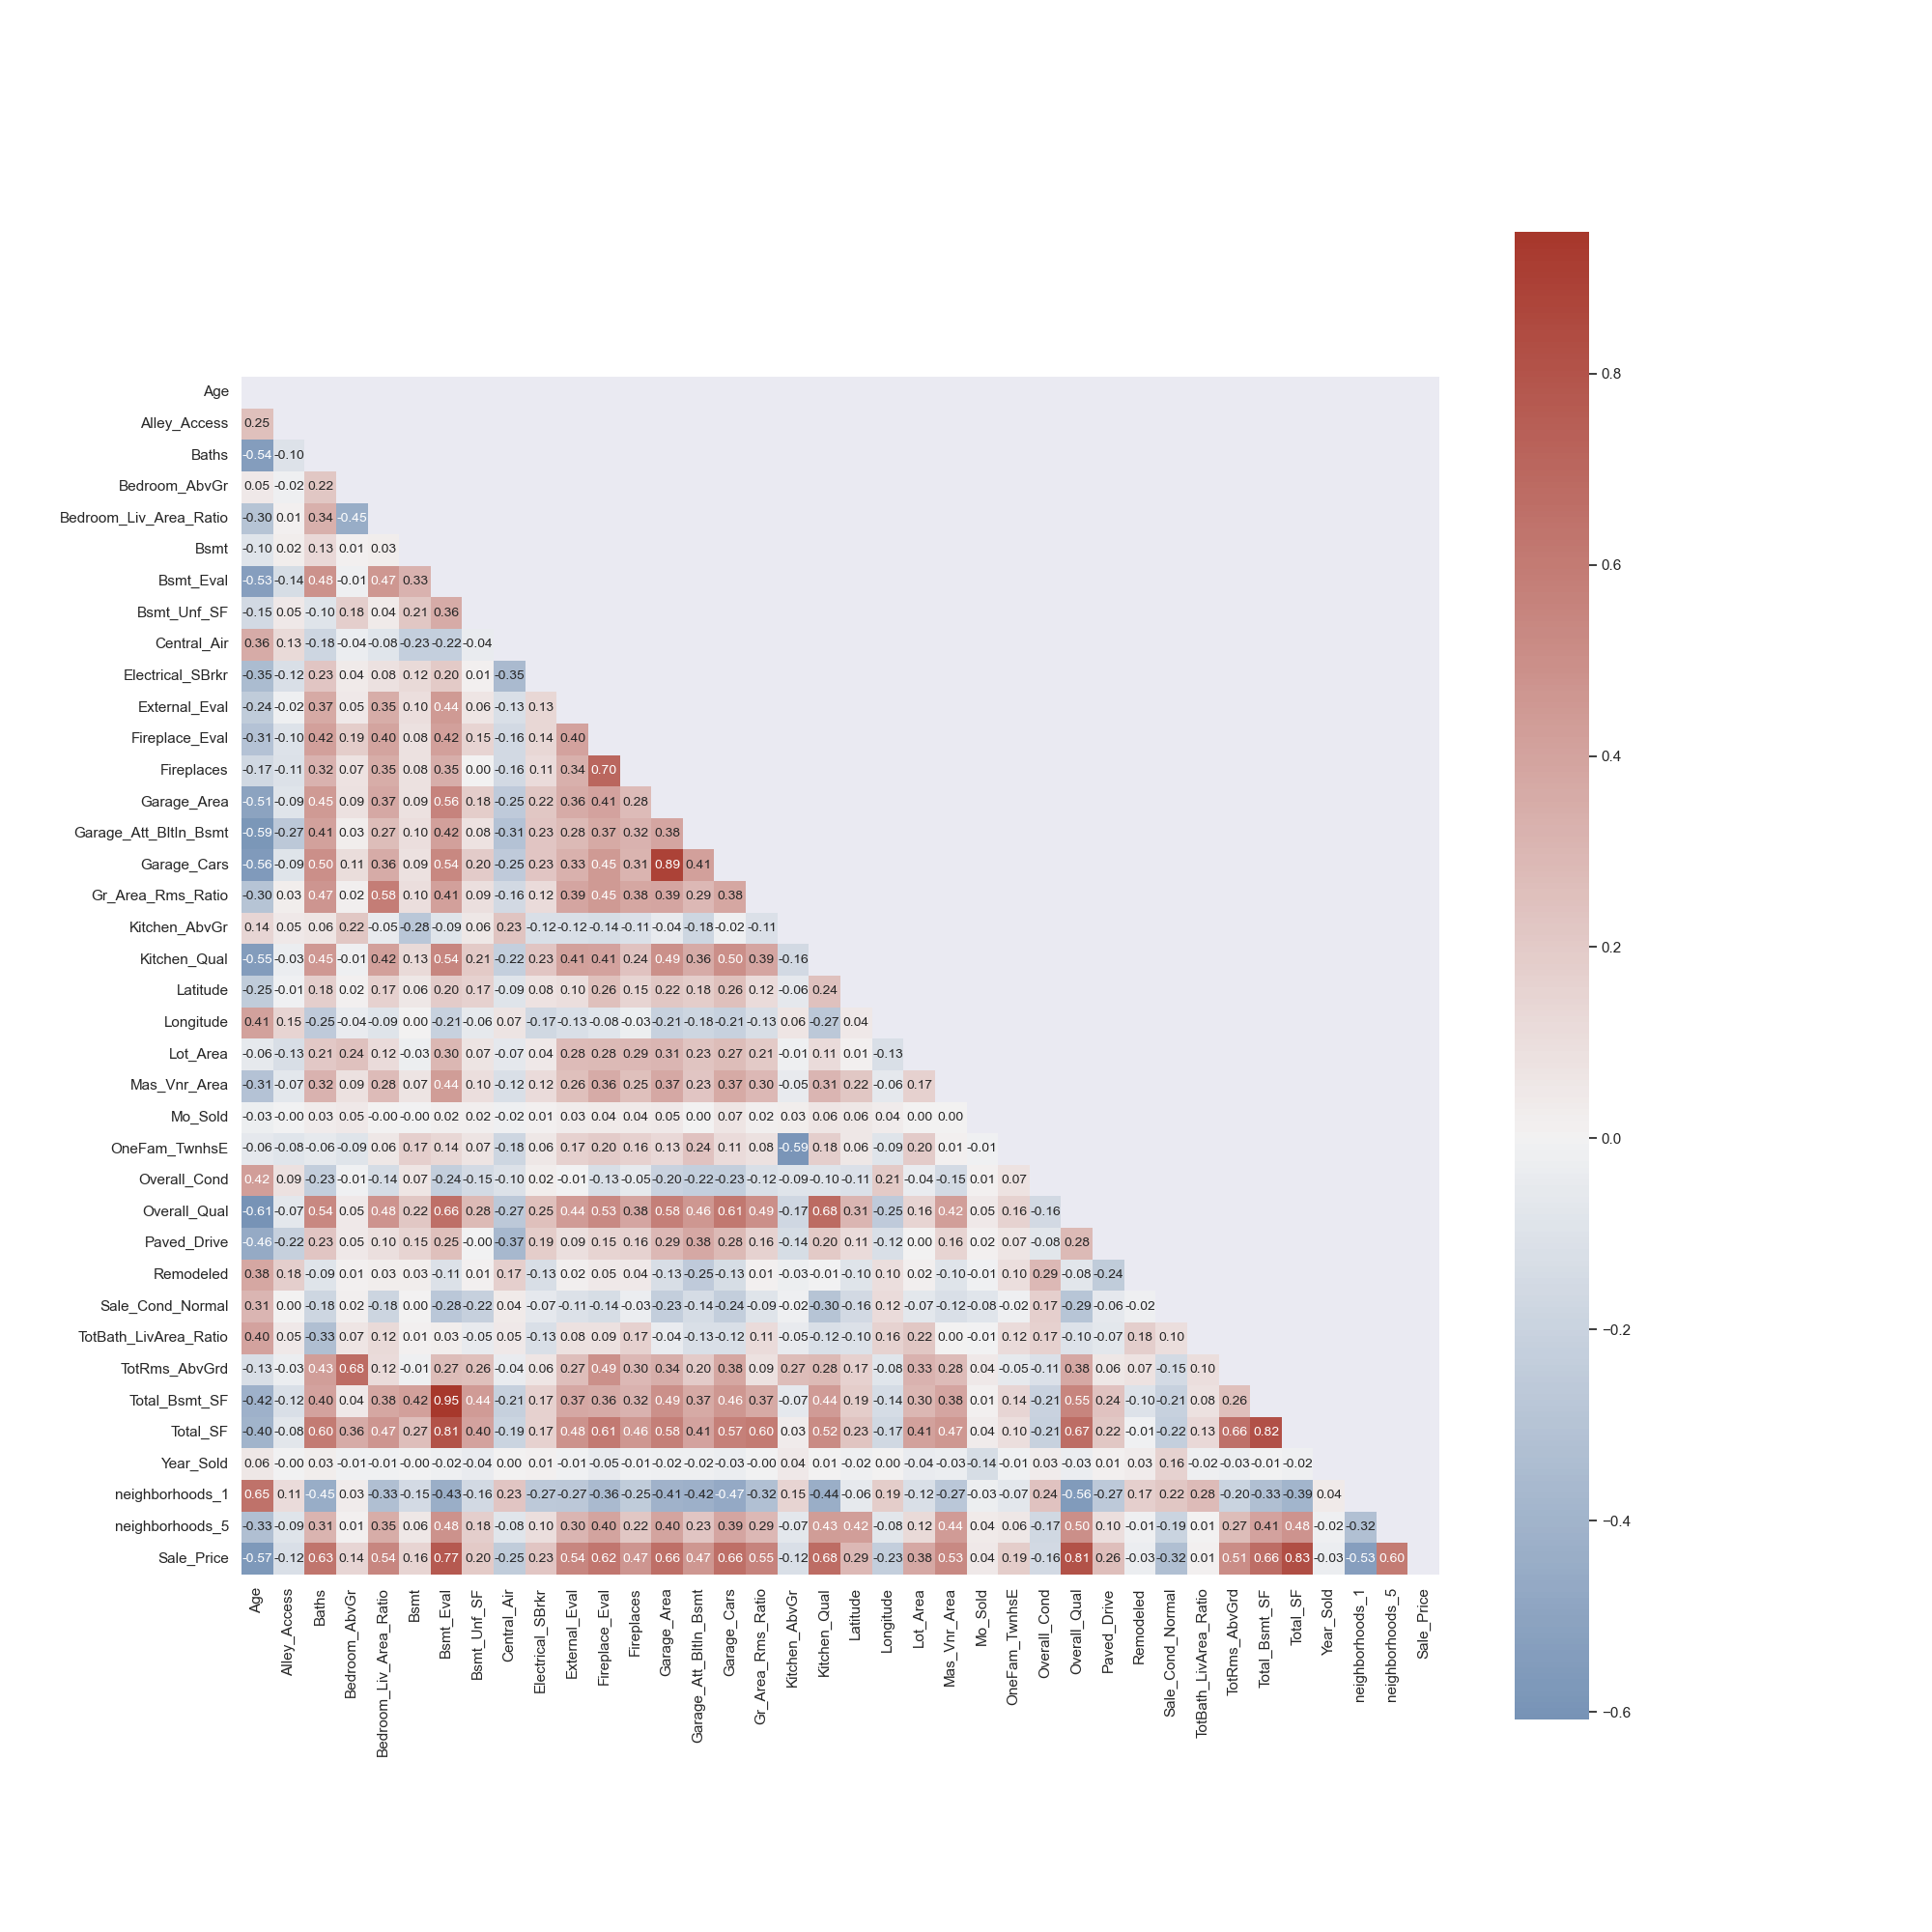

,Age,Alley_Access,Baths,Bedroom_AbvGr,Bedroom_Liv_Area_Ratio,Bsmt,Bsmt_Eval,Bsmt_Unf_SF,Central_Air,Electrical_SBrkr,...,Remodeled,Sale_Cond_Normal,TotBath_LivArea_Ratio,TotRms_AbvGrd,Total_Bsmt_SF,Total_SF,Year_Sold,neighborhoods_1,neighborhoods_5,Sale_Price
Age,1.000000,0.250451,-0.543651,0.052023,-0.297576,-0.096409,-0.531787,-0.152931,0.357669,-0.351822,...,0.378417,0.307502,0.403691,-0.132165,-0.415463,-0.402229,0.058816,0.647935,-0.333961,-0.573355
Alley_Access,0.250451,1.000000,-0.097734,-0.020398,0.006093,0.024387,-0.136455,0.045020,0.125170,-0.122710,...,0.179598,0.000508,0.053115,-0.032986,-0.118030,-0.078012,-0.004154,0.114327,-0.088078,-0.118099
Baths,-0.543651,-0.097734,1.000000,0.221018,0.339832,0.131690,0.484010,-0.096531,-0.180199,0.226181,...,-0.091346,-0.179584,-0.325475,0.427446,0.404112,0.602160,0.025180,-0.445710,0.313724,0.632384
Bedroom_AbvGr,0.052023,-0.020398,0.221018,1.000000,-0.446046,0.009054,-0.012285,0.181596,-0.035636,0.040737,...,0.008930,0.022059,0.066152,0.676756,0.043089,0.361873,-0.009980,0.032664,0.010821,0.144419
Bedroom_Liv_Area_Ratio,-0.297576,0.006093,0.339832,-0.446046,1.000000,0.028096,0.467416,0.036550,-0.080578,0.080700,...,0.029765,-0.183797,0.121803,0.118263,0.380651,0.473859,-0.007614,-0.331717,0.351206,0.544870
Bsmt,-0.096409,0.024387,0.131690,0.009054,0.028096,1.000000,0.327879,0.213028,-0.227103,0.122747,...,0.025560,0.003294,0.009287,-0.012584,0.418363,0.266231,-0.004969,-0.146654,0.057527,0.156487
Bsmt_Eval,-0.531787,-0.136455,0.484010,-0.012285,0.467416,0.327879,1.000000,0.361809,-0.223884,0.202961,...,-0.105727,-0.276938,0.028671,0.269597,0.948351,0.814305,-0.019996,-0.431845,0.481265,0.774297
Bsmt_Unf_SF,-0.152931,0.045020,-0.096531,0.181596,0.036550,0.213028,0.361809,1.000000,-0.037195,0.006311,...,0.010089,-0.217562,-0.046728,0.259860,0.439708,0.402042,-0.041246,-0.162990,0.179374,0.201508
Central_Air,0.357669,0.125170,-0.180199,-0.035636,-0.080578,-0.227103,-0.223884,-0.037195,1.000000,-0.352987,...,0.172259,0.040900,0.046151,-0.040675,-0.214669,-0.194771,0.003312,0.228824,-0.084022,-0.247128
Electrical_SBrkr,-0.351822,-0.122710,0.226181,0.040737,0.080700,0.122747,0.202961,0.006311,-0.352987,1.000000,...,-0.129840,-0.066760,-0.126036,0.061908,0.168353,0.167454,0.012823,-0.267334,0.099500,0.230422


In [25]:
display_corr_matrix(sort_alphabetically(df, 'Sale_Price'), label='Sale_Price')

<IPython.core.display.Javascript object>


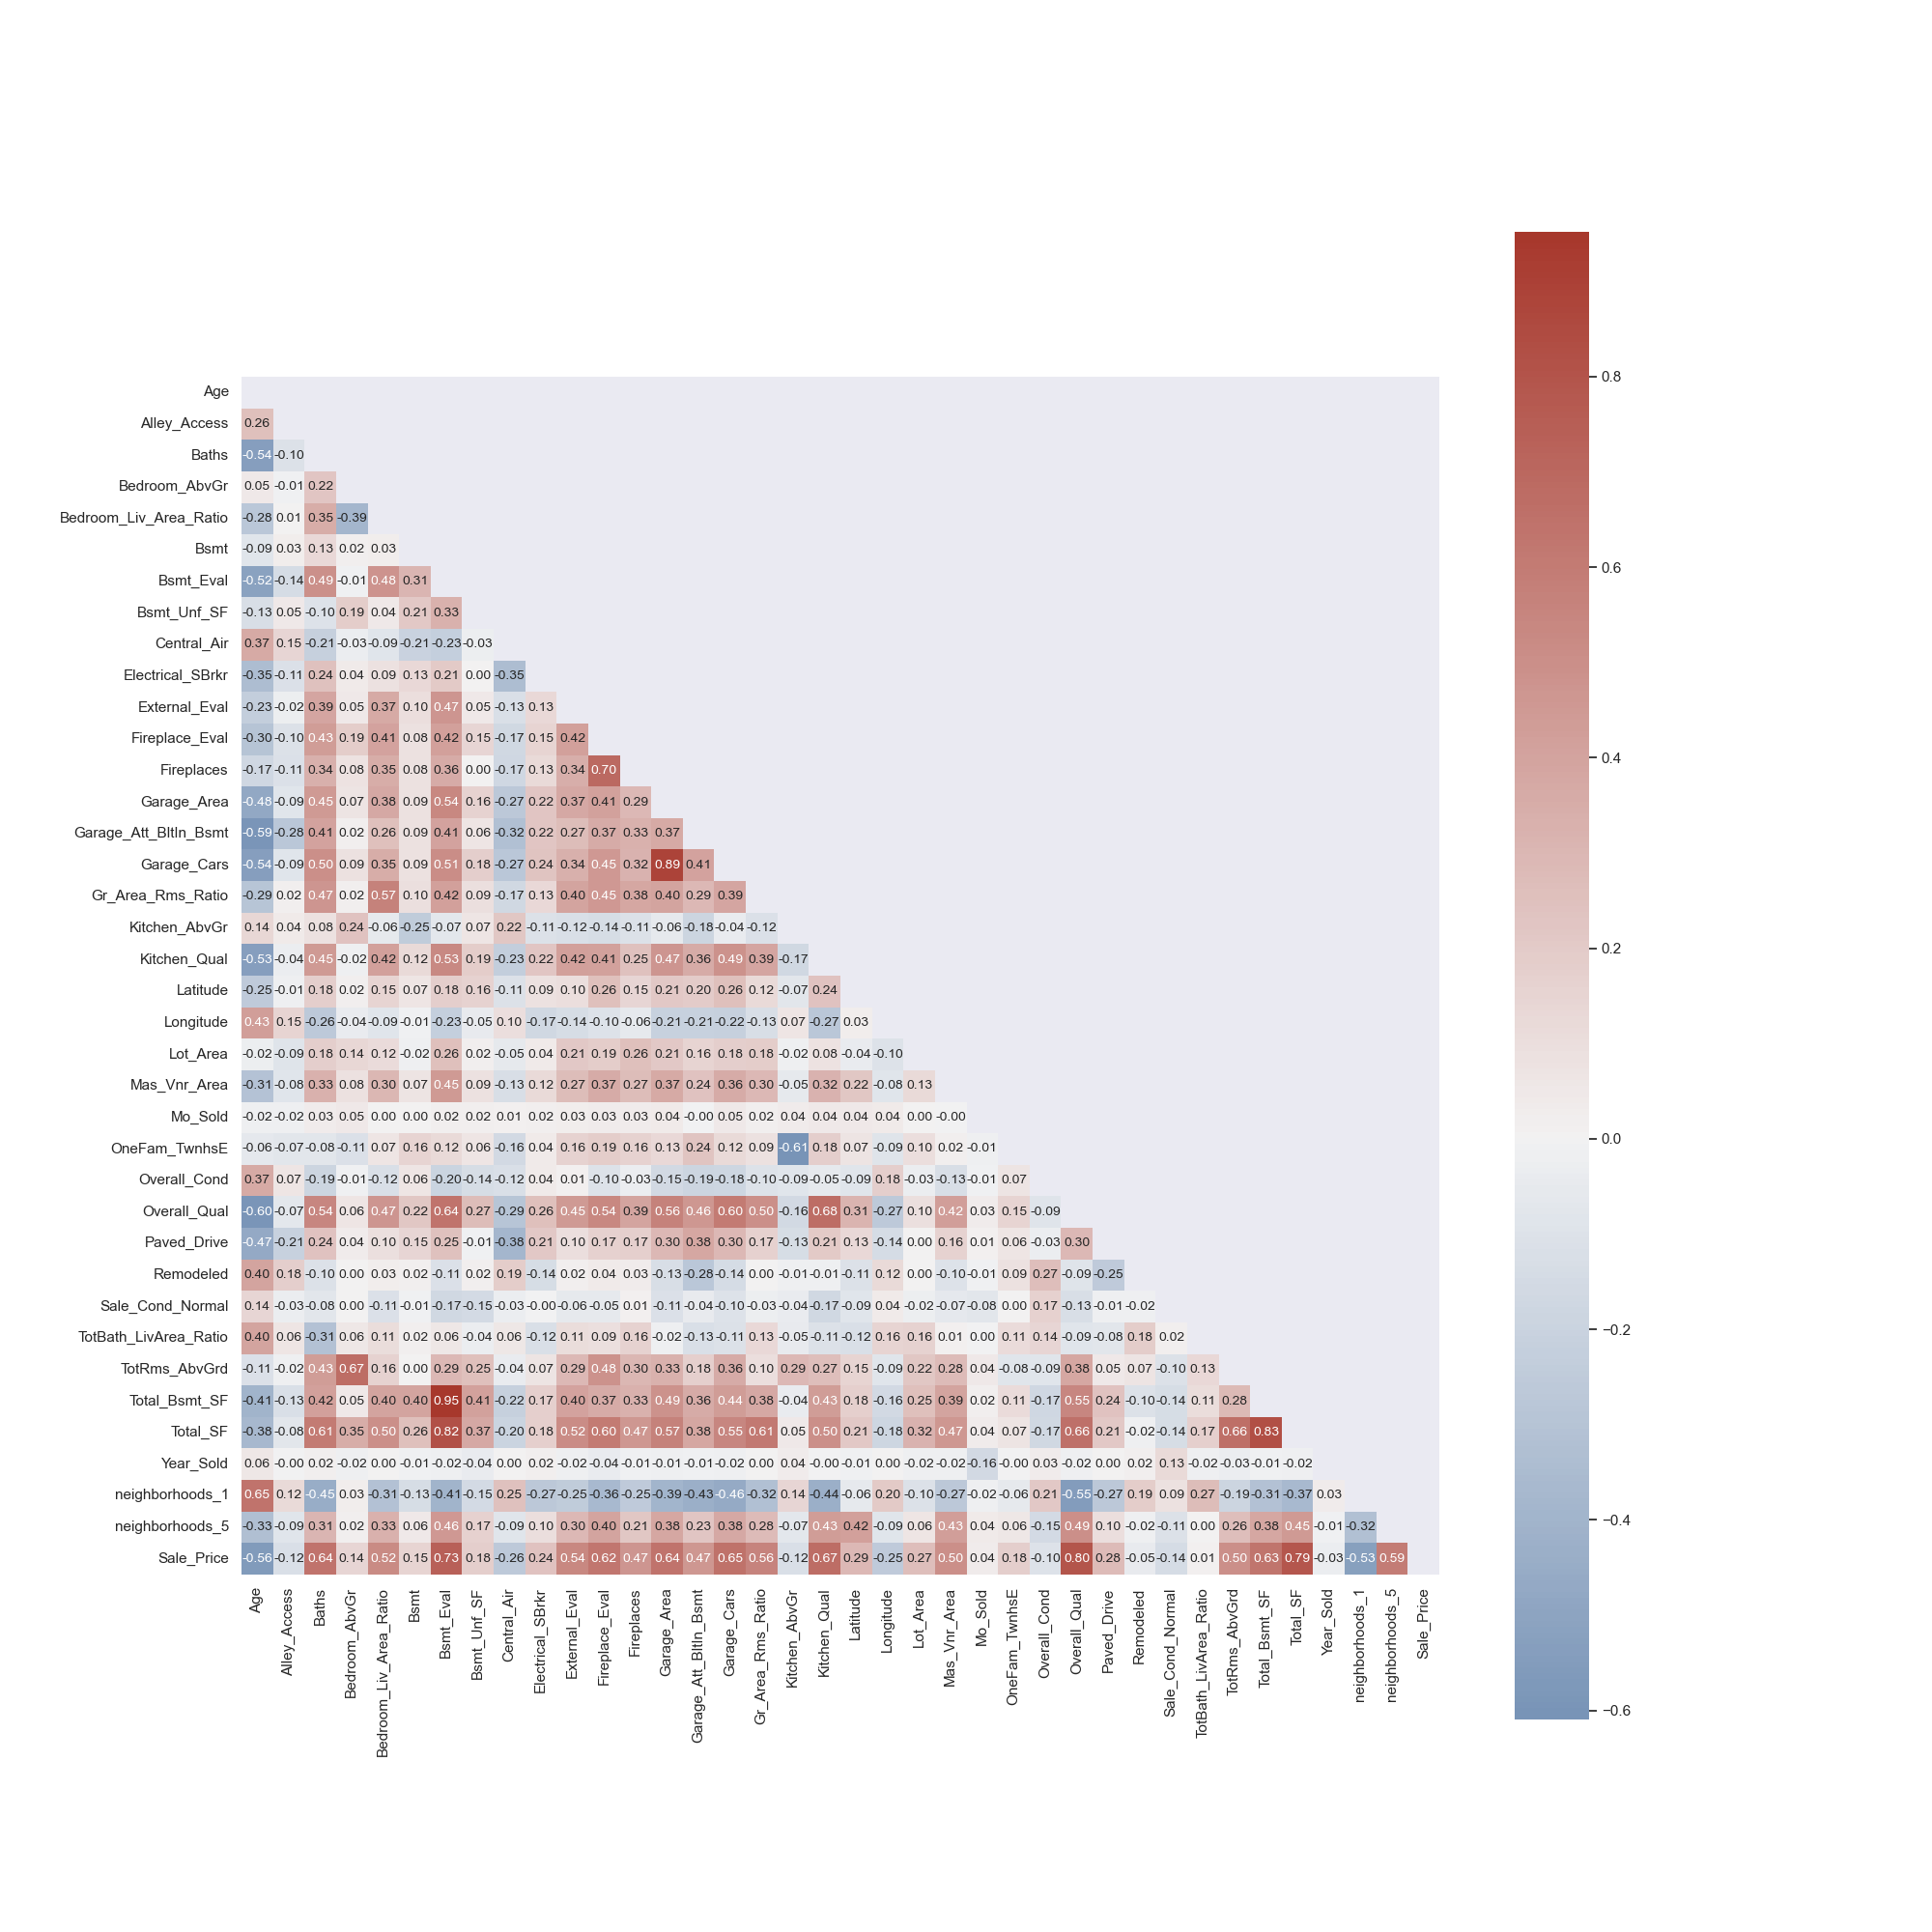

,Age,Alley_Access,Baths,Bedroom_AbvGr,Bedroom_Liv_Area_Ratio,Bsmt,Bsmt_Eval,Bsmt_Unf_SF,Central_Air,Electrical_SBrkr,...,Remodeled,Sale_Cond_Normal,TotBath_LivArea_Ratio,TotRms_AbvGrd,Total_Bsmt_SF,Total_SF,Year_Sold,neighborhoods_1,neighborhoods_5,Sale_Price
Age,1.000000,0.256298,-0.536645,0.054229,-0.276171,-0.089497,-0.517500,-0.130710,0.371259,-0.346408,...,0.400270,0.142508,0.397926,-0.113079,-0.407597,-0.375447,0.056653,0.646797,-0.334358,-0.558910
Alley_Access,0.256298,1.000000,-0.104668,-0.008452,0.005031,0.028418,-0.144102,0.045789,0.145603,-0.113526,...,0.182730,-0.032325,0.062045,-0.017044,-0.126199,-0.077167,-0.002590,0.124327,-0.088884,-0.122036
Baths,-0.536645,-0.104668,1.000000,0.221472,0.348439,0.129535,0.491904,-0.097314,-0.213567,0.244596,...,-0.103912,-0.075232,-0.311980,0.434170,0.420257,0.605158,0.023380,-0.445783,0.310618,0.636175
Bedroom_AbvGr,0.054229,-0.008452,0.221472,1.000000,-0.387808,0.018578,-0.007580,0.188508,-0.032083,0.042756,...,0.004419,0.000709,0.057854,0.672647,0.052721,0.353304,-0.018008,0.026957,0.015198,0.143913
Bedroom_Liv_Area_Ratio,-0.276171,0.005031,0.348439,-0.387808,1.000000,0.026346,0.482323,0.043578,-0.087163,0.086072,...,0.028492,-0.111472,0.105637,0.159191,0.403034,0.502653,0.000526,-0.311361,0.332472,0.522940
Bsmt,-0.089497,0.028418,0.129535,0.018578,0.026346,1.000000,0.310085,0.213140,-0.206615,0.129627,...,0.021669,-0.006131,0.017438,0.000586,0.399483,0.255268,-0.005989,-0.134469,0.055316,0.154369
Bsmt_Eval,-0.517500,-0.144102,0.491904,-0.007580,0.482323,0.310085,1.000000,0.331419,-0.226163,0.205303,...,-0.111716,-0.169390,0.059933,0.288208,0.952029,0.822198,-0.019188,-0.407875,0.456259,0.732459
Bsmt_Unf_SF,-0.130710,0.045789,-0.097314,0.188508,0.043578,0.213140,0.331419,1.000000,-0.026795,0.001671,...,0.020381,-0.150107,-0.036072,0.251633,0.412248,0.373823,-0.036443,-0.148801,0.170112,0.183308
Central_Air,0.371259,0.145603,-0.213567,-0.032083,-0.087163,-0.206615,-0.226163,-0.026795,1.000000,-0.345558,...,0.188877,-0.030158,0.058018,-0.039808,-0.218293,-0.196892,0.003189,0.245098,-0.088401,-0.264506
Electrical_SBrkr,-0.346408,-0.113526,0.244596,0.042756,0.086072,0.129627,0.205303,0.001671,-0.345558,1.000000,...,-0.137192,-0.002444,-0.116846,0.073182,0.174619,0.175331,0.023314,-0.268347,0.100398,0.239633


In [26]:
display_corr_matrix(sort_alphabetically(df_orig, 'Sale_Price'), label='Sale_Price')

The results obtained are very satisfying!

---

### Save the dataset

In [27]:
df[subset].to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_2.csv"))
df[f1].to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_2_f1.csv"))
df_orig[subset].to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_2_orig.csv"))